# Particle levels prediction using stateful LSTM networks

Long Short Term Memory networks (LSTM) are a type of Recurrent Neural Networks (RNN) that were specially designed to detect long-term dependencies in the data, making the training usually succesful for different time series problems. Finding these dependencies usually imply that they are able to find different trends in the data and predict which the following outcomes will be. To do so, the LSTM's (and in general, RNN networks) output will depend not only on its input, but also on its current state. To ensure that this state finds the long term dependencies (across training batches) we need to implement a stateful LSTM.

These properties seem specially important for predicting different pollution levels. This task, which is basically time series forecasting, is a good fit for LSTM and they are probably able to find different trends to predict from one day to the other. Using LSTMs will make it possible not to only use the recent training data, but also explore how different long-term trends may affect the forecast. Therefore, the main dataset used in this kernel will be the historical data of air pollution levels in Madrid, which has hourly data for the period 2001-2018.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set()
%matplotlib inline

Using TensorFlow backend.


Also, this notebook will not enter into the theorical details of how an LSTM works; it will instead focus on the implementation details of the network with Keras. If you are not familiar with RNN/LSTM architectures or want a crash course on how they work, these are the typical resources recommended to get some basic insight:
- [*Understanding LSTM Networks*](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), in Colah's Blog.
- [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), by Andrej Karpathy.

## Initial model: time-series forecasting

### Reading the data

For this task, we will use the records of a single station, `28079016`, which is one of the few that were active the whole 18 years period we are using to tune the model. However, not every particle was measured during 18 years, so we have to be careful when choosing which one will be used for the task.

In [4]:
with pd.HDFStore('./data/madrid.h5') as data:
    df = data['28079016']
    
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151776 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 7 columns):
CO      151182 non-null float64
NO      64045 non-null float64
NO_2    151290 non-null float64
NOx     92321 non-null float64
O_3     151131 non-null float64
PM10    75920 non-null float64
SO_2    78497 non-null float64
dtypes: float64(7)
memory usage: 9.3 MB


As we can see in the `missingno` plot, `CO`, `NO_2` and `O_3` are the most promising candidates, since there is a lot of data available.

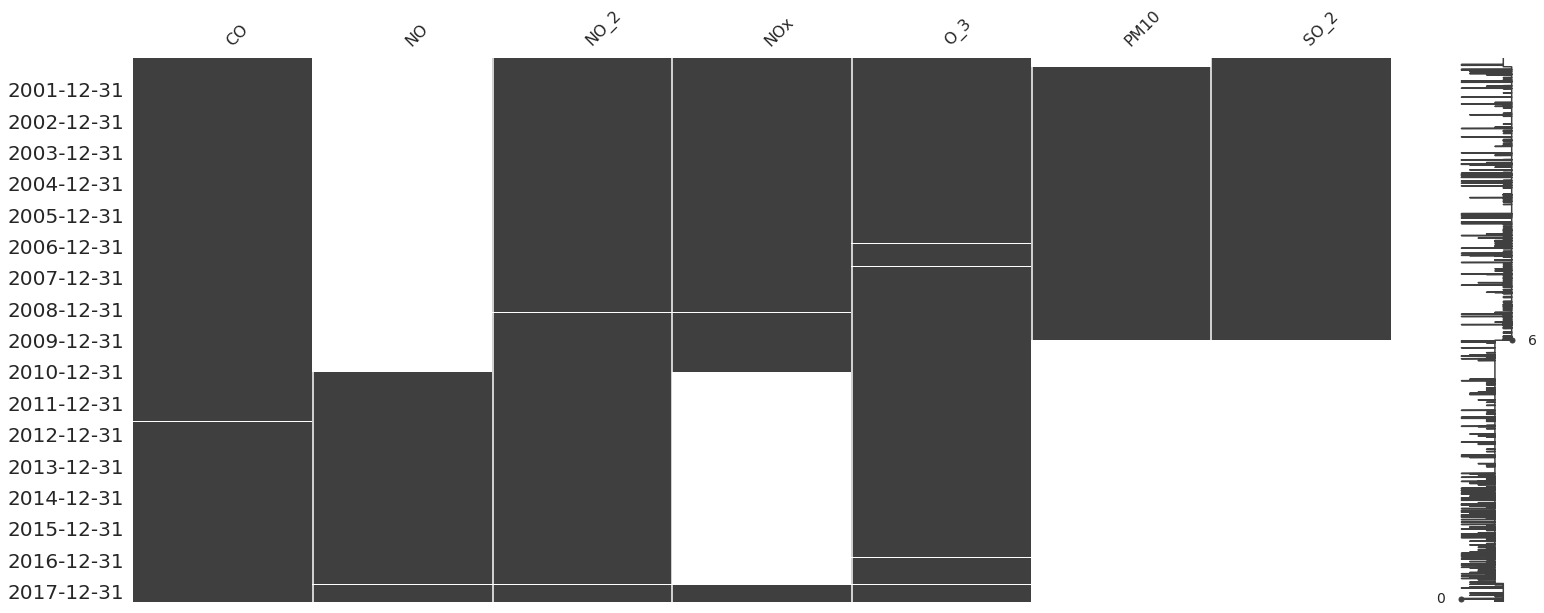

In [5]:
msno.matrix(df, freq='Y')

A quick check on the interpolated series for each particle reveals that all of them are quite similar: there is a noticeable yearly seasonality in all of them, and only the `CO` has a clear tendency to lower. Since `NO_2` is the one where the least amount of data had to be interpolated, let's stick to that one.

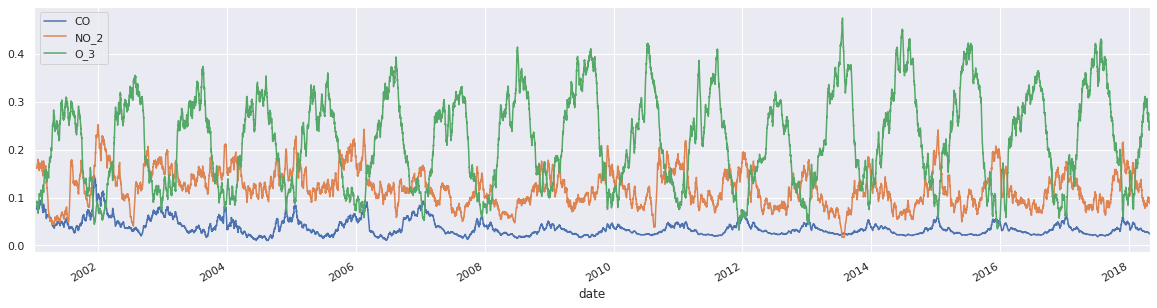

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))

candidates = df[['CO', 'NO_2', 'O_3']] 

candidates /= candidates.max(axis=0)

(candidates.interpolate(method='time')
           .rolling(window=24*15).mean()
           .plot(ax=ax))

### Data preparation

To prepare the data for the task, we will apply several steps to it. To smooth the variation in the curve to be predicted and be able to properly reconstruct it, we are going to apply the natural logarithm to the data. Also, our target is to input 24 timesteps to the network (a complete day, containing 24 hourly records) and make the network predict the next 24 timesteps (the next day). To do so, we want to pivot the next 48 hours for each sample into columns. We will apply this to the whole dataset and after it select the training examples with a 50% overlap: we will make a prediction not only at midnight but also at noon, which will force the data to be more general and generate twice as many examples.

In [7]:
def pivot_with_offset(series, offset):
    pivot = pd.DataFrame(index=df.index)

    for t in range(offset * 2):
        pivot['t_{}'.format(t)] = series.shift(-t)

    pivot = pivot.dropna(how='any')
    return pivot


offset = 24

series = (df.NO_2.interpolate(method='time')
                 .pipe(pivot_with_offset, offset)
                 .apply(np.log, axis=1)
                 .replace(-np.inf))

# Get only timestamps at 00:00 and 12:00
series = series[(series.index.hour % 12) == 0]

# Make it a multiple of the chosen batch_size
if series.shape[0] % 32 != 0:
    series = series.iloc[:-(series.shape[0]%32)]

The next step is to split the series into features and labels: the first 24 hours of each row will be used to predict (`X`) and the next 24 hours will be the levels that we aim to predict (`y`). Also we need to split before starting to do more data processing into train and test data: 20% of the data will not be used for learning. Instead, it will be used to check that the model is able to generalize to new data properly. Take into account that these are time-stamped data and we are training a stateful network: make sure that the data is kept in its original order!

In [8]:
test_ratio = 0.2

split_point = int(series.shape[0] * (1 - test_ratio))
split_point -= split_point % 32

np_series = series.values

X_train = series.values[:split_point , :offset]
y_train = series.values[:split_point, offset:]
X_test = series.values[split_point:, :offset]
y_test = series.values[split_point:, offset:]

Also, it is important to notice that Keras requires a certain shape for the input data: a three dimensional input array with the shape (*batch-size*, *timesteps*, *features*). If we are going predict 24 hours based solely on the previous 24 hours records, we have 24 timesteps and 1 single feature (the `NO_2` levels). We also want the data to be scaled in the interval $[0, 1]$ - most machine learning techniques perform better with normalized features. However, make sure to scale the data only to the training data (you technically do not have the test one, that is what you want to predict): doing so is a form of look-ahead bias and we should keep it legit.

In [9]:
# Scale only to train data to prevent look-ahead bias
lift = X_train.min()
scale = X_train.max()

def scale_array(arr, lift, scale):
    return (arr - lift) / scale

X_train = np.expand_dims(scale_array(X_train, lift, scale), axis=2)
y_train = np.expand_dims(scale_array(y_train, lift, scale), axis=2)
X_test = np.expand_dims(scale_array(X_test, lift, scale), axis=2)

### Network architecture

We will use Keras to implement the network, and our best option is to write a function to do it (since we might be doing this quite a few times). Building on top of the Sequential model, we want to add a first `LSTM` layer of a certain size, maybe a second `LSTM` layer and a `TimeDistributed` - `Dense` layer to predict each of the 24 target timestamps. Make sure to check that `stateful=True` for the LSTM layers and that the `batch_input_shape` is correctly configured as described previously. The optimizer will be `RMSprop` and the loss function will be a simple mean squared error.

In [10]:
def create_lstm(offset, neurons=(2,1), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(
        neurons[0], return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    
    
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1], return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
    
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

Since the model is stateful, we want to reset the state of the network after each epoch. This does not erase the weights learned, instead it just resets the state to be fed via the context neurons. To do so, we can define a function to perform this workaround.

In [11]:
def train_model(model, X_train, y_train, batch_size=32, epochs=20):
    mse = list()

    for i in range(epochs):
        if i % 1 == 0:
            print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(
            X_train, y_train, 
            epochs=1, batch_size=32, 
            verbose=0, shuffle=False
        )
    
        mse.append(log.history['loss'][-1])
        print('loss: {:.4f}'.format(mse[-1]))
    
        model.reset_states()
        
    return model, mse

### Evaluation of the model

A function to automatically compute the mean squared error to the data and reset the state of the machine may come in handy when looking for a good architecture or hyperparameters.

In [12]:
def validate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    model.reset_states()
    return np.mean((y_test - preds) ** 2)

After my experimentation, I came to the realization that a few number of neurons and favor a lot of epochs rather than higher learning rates is the best way to approach the problem. This is still a craft, so the best bet is still to just imitate other architectures that have been proved to work or to perform a grid search on the hyperparameters (in this case, the number of hidden neurons, the learning rate and the training epochs).

In [13]:
model = create_lstm(offset)
model, _ = train_model(model, X_train, y_train)

model.fit(
    X_train, y_train, 
    epochs=1, batch_size=32, 
    verbose=1, shuffle=False
)
model.reset_states()

preds = model.predict(X_test)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 01/20... WARNING:tensorflow:From /home/jan/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
loss: 0.0546
Epoch 02/20... loss: 0.0134
Epoch 03/20... loss: 0.0124
Epoch 04/20... loss: 0.0116
Epoch 05/20... loss: 0.0110
Epoch 06/20... loss: 0.0106
Epoch 07/20... loss: 0.0106
Epoch 08/20... loss: 0.0106
Epoch 09/20... loss: 0.0106
Epoch 10/20... loss: 0.0106
Epoch 11/20... loss: 0.0106
Epoch 12/20... loss: 0.0106
Epoch 13/20... loss: 0.0106
Epoch 14/20... loss: 0.0106
Epoch 15/20... loss: 0.0106
Epoch 16/20... loss: 0.0106
Epoch 17/20... loss: 0.0106
Epoch 18/20... loss: 0.0106
Epoch 19/20... loss: 0.0106
Epoch 20/20... loss: 0.0106
Epoch 1/1
10112/10112 [==============================] - 3s 291us/step - loss: 0.0106


A quick validation of the model reveals that the MSE is slightly larger than the one for the training data. Still, the model seems to generalize good enough, so let us check how does the network predict future trends in the data.

In [33]:
X_test[0]

array([[0.88502846],
       [0.85319672],
       [0.88177037],
       [0.80399034],
       [0.70031427],
       [0.74224107],
       [0.81887314],
       [0.84523974],
       [0.86079994],
       [0.86807952],
       [0.83256399],
       [0.77588725],
       [0.79329659],
       [0.79872703],
       [0.73463785],
       [0.70031427],
       [0.65732837],
       [0.56160929],
       [0.59977672],
       [0.76966677],
       [0.85319672],
       [0.90624695],
       [0.91185547],
       [0.88177037]])

In [34]:
y_test[0]

array([3.98898405, 4.11087386, 3.98898405, 4.00733319, 4.24849524,
       4.30406509, 4.20469262, 4.24849524, 4.27666612, 4.07753744,
       3.95124372, 3.80666249, 3.09104245, 2.7080502 , 2.7080502 ,
       2.39789527, 2.19722458, 2.07944154, 2.07944154, 2.89037176,
       3.78418963, 3.73766962, 3.71357207, 3.40119738])

In [29]:
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))

ValueError: operands could not be broadcast together with shapes (2528,24) (2528,24,1) 

Doing a quick plot of a slice of two weeks in the testing data and plotting several predictions show that, even though the network shows potential, the model can be still improved: the main problem is that the data seems to be failing in scale and the predictions are quite linear. However, it is possible to see that some peaks are correctly predicted.

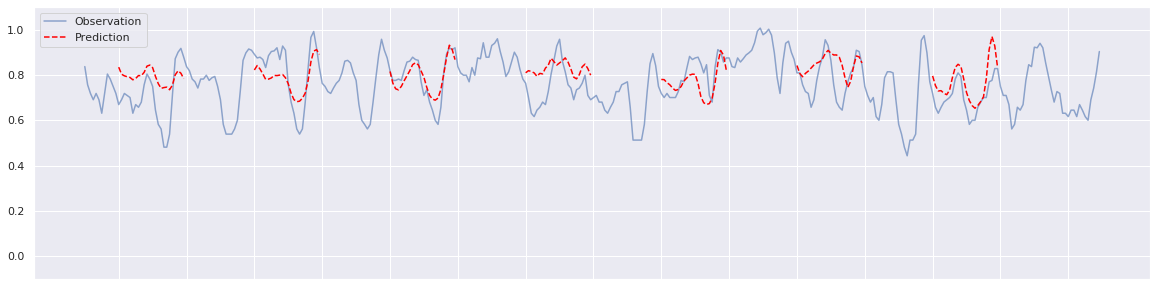

In [23]:
fig, ax = plt.subplots(figsize=(20, 5))

start = X_test.shape[0] - 42
interval = X_test[start+3:start+33:2, :, 0].reshape(-1, 1)

truth, = plt.plot(np.arange(24*15), interval, alpha=0.6)

old_preds = list()

for point in range(1, 15, 2):
    prediction = np.squeeze(preds[start + point*2])
    pred, = plt.plot(point * offset + np.arange(offset) - 12, prediction,
                     linestyle='--', color='red')
    old_preds.append(prediction)

plt.legend(
    [truth, pred],
    ['Observation', 'Prediction']
)
ax.set_ylim([-.1, 1.1])
ax.set_xticks(12 + np.arange(15) * offset)
_ = ax.set_xticklabels([])